(week4:coords)=
# Geographic coordinate systems

The pamphlet:

[Understanding map projections](https://clouds.eos.ubc.ca/~phil/courses/eosc582/downloads/understanding_map_projections.pdf)

Introduces geographic coordinate systems in Chapter 1.  They solve the problem of how to locate yourself on the earth's surface in three dimensions.  They specify an angular measure of units, a prime meridian, a spheroid and a datam (see chapter 1).

## Basic points

We need to define two fundamental things:

1.  A "[datum](https://www.maptools.com/tutorials/map_datum)"  (called a "globe" in cartopy) that gives the three dimensional shape of the earth (and other things)

1.  A "[projection](https://en.wikipedia.org/wiki/List_of_map_projections)" that maps a point on the earth's surface onto an x-y coordinate system to make a 2-dimensional plot.

1.  Our mapping module is called [cartopy](http://scitools.org.uk/cartopy/docs/latest/index.html).  Internally, it uses projection code in [pyproj](https://github.com/jswhit/pyproj), which in turn is a wrapper around C code called
[proj4](https://proj4.org/usage/projections.html)

## An example

The [Equal Area Scalable Earth Grid](https://nsidc.org/data/ease)

1. Datum: The original EASE grid assumed a spherical earth with a radius of 6371.228 km.  [EASE-2](https://nsidc.org/data/ease/versions.html) uses a datum called [WGS 84](https://en.wikipedia.org/wiki/World_Geodetic_System)

1. Both EASE and EASE-2 use the [Lambert Azimuthal Equal Area](https://en.wikipedia.org/wiki/Lambert_azimuthal_equal-area_projection) or LAEA

# Map projections

Chapter 2 describes map projections.  We will generally be using the LAEA projection for individual Modis granules.

## plotting Vancouver on a map


### Step 1: Use [cartopy](http://scitools.org.uk/cartopy/docs/latest/index.html) to make a LAEA map of BC including Vancouver.



In [1]:
import a301_lib
from pathlib import Path
from pyhdf.SD import SD, SDC
from matplotlib import pyplot as plt

In [2]:
myd03_file_name = list(a301_lib.sat_data.glob("MYD03*hdf"))[0]
print(myd03_file_name)

/Users/phil/work/sat_data/MYD03.A2014213.1715.006.2014214154316.hdf


## What's in the file?

In [3]:
m3_file = SD(str(myd03_file_name), SDC.READ)
print(m3_file.info())
datasets_dict = m3_file.datasets()
for idx, sds in enumerate(datasets_dict.keys()):
    print(idx, sds)


(46, 27)
0 Latitude
1 Longitude
2 Scan Offset
3 Track Offset
4 Height Offset
5 Height
6 SensorZenith
7 SensorAzimuth
8 Range
9 SolarZenith
10 SolarAzimuth
11 Land/SeaMask
12 WaterPresent
13 gflags
14 Scan number
15 EV frames
16 SD frames
17 SV frames
18 EV start time
19 SD start time
20 SV start time
21 EV center time
22 Mirror side
23 SD Sun zenith
24 SD Sun azimuth
25 Moon Vector
26 L1 scan quality
27 Geo scan quality
28 orb_pos
29 orb_vel
30 T_inst2ECR
31 attitude_angles
32 sun_ref
33 num_impulse
34 impulse_enc
35 impulse_time
36 Scan Type
37 thermal_correction
38 attitude_quality
39 ephemeris_quality
40 Focal_length
41 band_position
42 detector_space
43 detector_offsets
44 T_offset
45 num_samples


## Read the lats and lons into array

In [4]:
lats = m3_file.select('Latitude').get()
lons = m3_file.select('Longitude').get()
print(lats.shape, lons.shape)

(2030, 1354) (2030, 1354)


In [5]:
## Note the overlap in the 10 scanlines

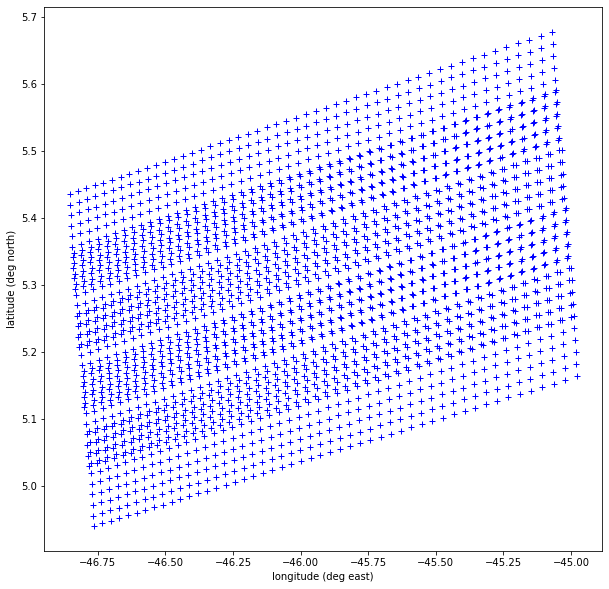

In [6]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.plot(lons[:50,:50],lats[:50,:50],"b+")
ax.set(xlabel="longitude (deg east)",ylabel="latitude (deg north)");

## Now choose the Lambert project for our map

**This cell sets up the datum and the LAEA projection, with the tangent point at the North Pole and the central meridian at -90 degrees west of Greenwich**

In [7]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy
from pathlib import Path
import pprint
import numpy as np

#
# Datum: radius of the earth in meters
#
radius = 6_371_228

#
# vancouver longitude, latitude indegrees
#
van_lon, van_lat = [-123.1207, 49.2827]
#
# use a simple sphere as the datum
#
globe = ccrs.Globe(ellipse=None, semimajor_axis=radius, semiminor_axis=radius)
#
# set up
#
projection = ccrs.LambertAzimuthalEqualArea(
    central_latitude=90, central_longitude=-90, globe=globe
)
print(f"pro4 program params: {projection.proj4_params}")

pro4 program params: {'a': 6371228, 'b': 6371228, 'proj': 'laea', 'lon_0': -90, 'lat_0': 90, 'x_0': 0.0, 'y_0': 0.0}


**Use matplotlib to draw the map and add a coastline**

/Users/phil/a50037/envs/june22/lib/python3.7/site-packages/shapefile.py:385: UserWarning: Shapefile shape has invalid polygon: no exterior rings found (must have clockwise orientation); interpreting holes as exteriors.
  warnings.warn('Shapefile shape has invalid polygon: no exterior rings found (must have clockwise orientation); interpreting holes as exteriors.')


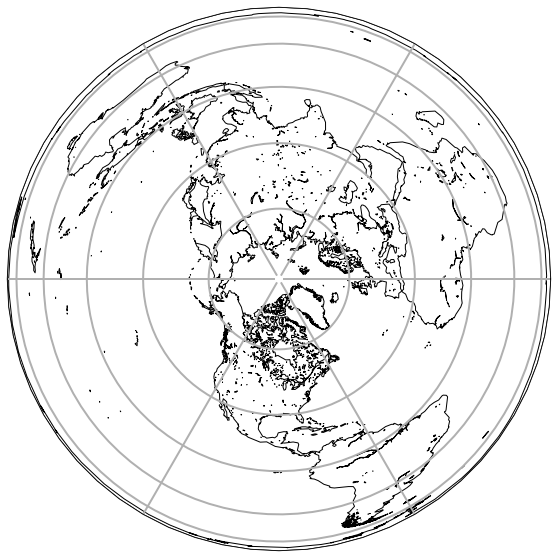

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={"projection": projection})
ax.gridlines(linewidth=2)
ax.add_feature(cartopy.feature.GSHHSFeature(scale="coarse", levels=[1, 2, 3]))

##  zoom in on vancouver

The next step is to pick an bounding box in map coordinates (the "extent") to limit the map area

The idea is to reduce the extent of the map to a region that is only a fraction
of the original full globe.  The strategy is to find a point in your swath and
get it's x,y coords, then use that to set the corners of the map so that
you have your region of interest

In [11]:
#
# pick a bounding box in map coordinates
# (we know from the next cell that vancouver is located
# at x,y = -2_422_235, -3_721_768  so pick a bounding box
# based on that
#
xleft, xright = -4_000_000, -800_000
ybot, ytop = -4_700_000, -3_100_000


## Use the transform_point method to get x,y on this projection

This is how we put Vancouver (in lon,lat coords) on the map (in LAEA x,y coords)

-2422235.2316723852 -3712768.5862524547


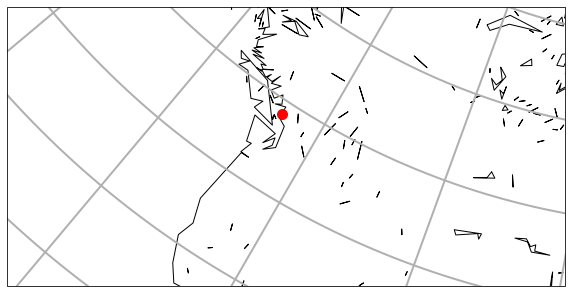

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={"projection": projection})
#
# clip with 0,0 in the center:  [xleft, xright, ybot, ytop]
#
new_extent = [xleft, xright, ybot, ytop]
ax.set_extent(new_extent, projection)
#
# the simple lon,lat projection is called "geodetic"
#
geodetic = ccrs.Geodetic()
van_x, van_y = projection.transform_point(van_lon, van_lat, geodetic)
ax.plot(van_x, van_y, "ro", markersize=10)
ax.gridlines(linewidth=2)
ax.add_feature(cartopy.feature.GSHHSFeature(scale="coarse", levels=[1, 2, 3]))
print(van_x, van_y);